# Loading libraries, datasets

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import spacy
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("zynicide/wine-reviews")

print("Path to dataset files:", path)

100%|██████████| 50.9M/50.9M [00:01<00:00, 35.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/zynicide/wine-reviews/versions/4


In [ ]:
!ls /root/.cache/kagglehub/datasets/zynicide/wine-reviews/versions/4

winemag-data-130k-v2.csv  winemag-data-130k-v2.json  winemag-data_first150k.csv


In [ ]:
# Load the dataset

# file_path = os.path.join(path, 'winemag-data_first150k.csv')
# file_path = os.path.join(path, 'winemag-data-130k-v2.csv')
file_path = os.path.join(path, 'winemag-data-130k-v2.json')

# df = pd.read_csv(file_path)
df = pd.read_json(file_path)
df.head()

,points,title,description,taster_name,taster_twitter_handle,price,designation,variety,region_1,region_2,province,country,winery
0,87,Nicosia 2013 Vulkà Bianco (Etna),"Aromas include tropical fruit, broom, brimston...",Kerin O’Keefe,@kerinokeefe,NaN,Vulkà Bianco,White Blend,Etna,None,Sicily & Sardinia,Italy,Nicosia
1,87,Quinta dos Avidagos 2011 Avidagos Red (Douro),"This is ripe and fruity, a wine that is smooth...",Roger Voss,@vossroger,15.0,Avidagos,Portuguese Red,None,None,Douro,Portugal,Quinta dos Avidagos
2,87,Rainstorm 2013 Pinot Gris (Willamette Valley),"Tart and snappy, the flavors of lime flesh and...",Paul Gregutt,@paulgwine,14.0,None,Pinot Gris,Willamette Valley,Willamette Valley,Oregon,US,Rainstorm
3,87,St. Julian 2013 Reserve Late Harvest Riesling ...,"Pineapple rind, lemon pith and orange blossom ...",Alexander Peartree,None,13.0,Reserve Late Harvest,Riesling,Lake Michigan Shore,None,Michigan,US,St. Julian
4,87,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,"Much like the regular bottling from 2012, this...",Paul Gregutt,@paulgwine,65.0,Vintner's Reserve Wild Child Block,Pinot Noir,Willamette Valley,Willamette Valley,Oregon,US,Sweet Cheeks


In [ ]:
df.shape

(129971, 13)

In [ ]:
df.columns

Index(['points', 'title', 'description', 'taster_name',
       'taster_twitter_handle', 'price', 'designation', 'variety', 'region_1',
       'region_2', 'province', 'country', 'winery'],
      dtype='object')

# Handling NaNs, duplicates, and changing dtypes

In [ ]:
# drops all duplicate rows
df.drop_duplicates(inplace=True)

In [ ]:
# lets see what columns are missing
df.isnull().sum()

,0
points,0
title,0
description,0
taster_name,24917
taster_twitter_handle,29446
price,8395
designation,34545
variety,1
region_1,19560
region_2,73219


In [ ]:
# taster_name
# Replace Nans in taster name with "anonymous" instead
# speaking of alcoholic anonymous...

df['taster_name'] = df['taster_name'].fillna("anonymous")

In [ ]:
# Convert 'price' column to numeric, coercing errors to NaN
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Imputing missing values with mean
df['price'].fillna(df['price'].mean(), inplace=True)

<ipython-input-10-ca2235d79535>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['price'].fillna(df['price'].mean(), inplace=True)


In [ ]:
df.dtypes

,0
points,int64
title,object
description,object
taster_name,object
taster_twitter_handle,object
price,float64
designation,object
variety,object
region_1,object
region_2,object


# General EDA

There are 44 different countries represented in the dataset


<Axes: title={'center': 'Count of wine reviews from the top 15 countries'}, xlabel='country'>

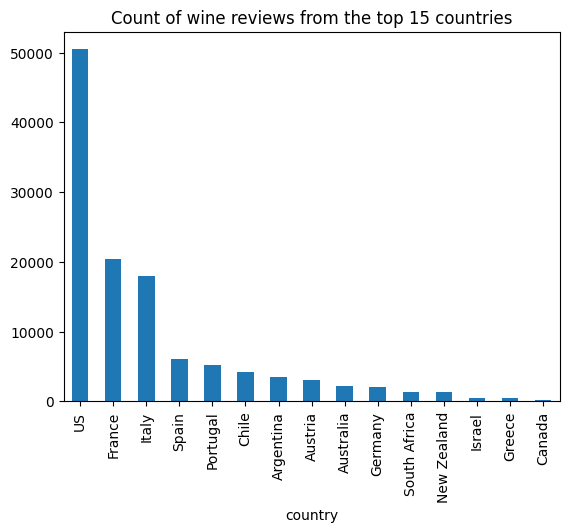

In [ ]:
# To get an idea of wineries in countries for detecting trends
print(f'There are {len(pd.unique(df.country))} different countries represented in the dataset')

# Visualizing the above information
countries_count = df['country'].value_counts()
countries_count[:15].plot(kind='bar', title="Count of wine reviews from the top 15 countries")

# From this information we can see that wineries are most popular in U.S, Italy, France, Spain, and Chile
# Due to the lack of data in many countries we should not try to look at every country when doing further analysis

In [ ]:
print("The following countries make up 80% of all reviews in the dataset")
print((countries_count>countries_count.quantile(0.8)).index.values)

The following countries make up 80% of all reviews in the dataset
['US' 'France' 'Italy' 'Spain' 'Portugal' 'Chile' 'Argentina' 'Austria'
 'Australia' 'Germany' 'South Africa' 'New Zealand' 'Israel' 'Greece'
 'Canada' 'Bulgaria' 'Hungary' 'Romania' 'Uruguay' 'Turkey' 'Slovenia'
 'Georgia' 'Croatia' 'Mexico' 'England' 'Moldova' 'Brazil' 'Lebanon'
 'Morocco' 'Peru' 'Ukraine' 'Czech Republic' 'Macedonia' 'Cyprus' 'Serbia'
 'India' 'Switzerland' 'Luxembourg' 'Bosnia and Herzegovina' 'Armenia'
 'Slovakia' 'China' 'Egypt']


There are 16757 different wineries represented in the dataset
72.64% of all wineries have at least 2 reviews


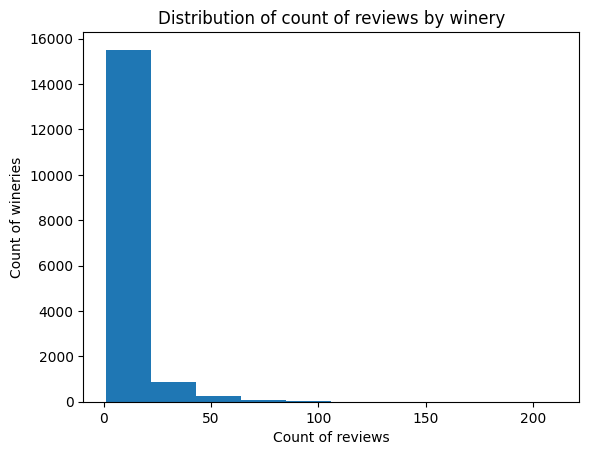

In [ ]:
print(f'There are {len(pd.unique(df.winery))} different wineries represented in the dataset')

count_of_wineries = df['winery'].value_counts()
# Visualizing the above information
count_of_wineries.plot(
    kind='hist',
    title="Distribution of count of reviews by winery",
    xlabel='Count of reviews',
    ylabel='Count of wineries'
)

print(f'{100*sum(count_of_wineries>=2)/len(count_of_wineries):0.2f}% of all wineries have at least 2 reviews')

In [ ]:
#types of wines and count
print(len(pd.unique(df['variety'])))
print(pd.unique(df['variety'])[:20])

708
['White Blend' 'Portuguese Red' 'Pinot Gris' 'Riesling' 'Pinot Noir'
 'Tempranillo-Merlot' 'Frappato' 'Gewürztraminer' 'Cabernet Sauvignon'
 'Nerello Mascalese' 'Chardonnay' 'Malbec' 'Tempranillo Blend' 'Meritage'
 'Red Blend' 'Merlot' "Nero d'Avola" 'Chenin Blanc' 'Gamay'
 'Sauvignon Blanc']


In [ ]:
sum(count_of_wineries<200)

16753

72.64% of all wineries have at least 2 reviews


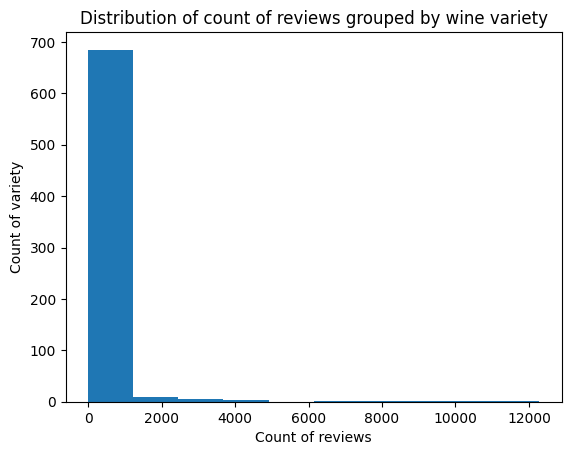

In [ ]:
count_variety = df.variety.value_counts()
count_variety.plot(
    kind='hist',
    title="Distribution of count of reviews grouped by wine variety",
    xlabel='Count of reviews',
    ylabel='Count of variety'
)

print(f'{100*sum(count_of_wineries>=2)/len(count_of_wineries):0.2f}% of all wineries have at least 2 reviews')

There are 118840 different wines represented in the dataset
Around 99.21% of all wines have fewer than 2 reviews


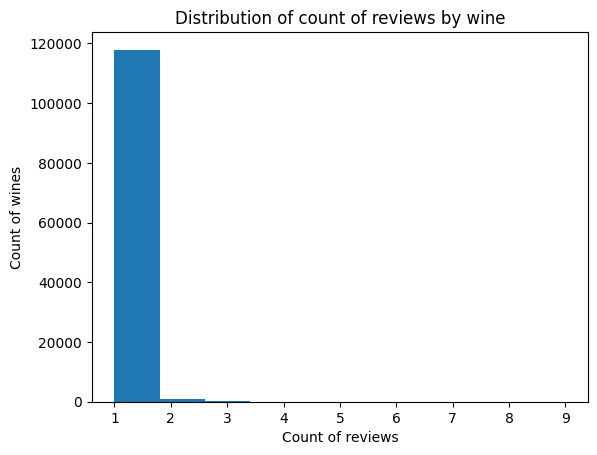

In [ ]:
print(f'There are {len(pd.unique(df.title))} different wines represented in the dataset')

count_titles = df.title.value_counts()
count_titles.plot(
    kind='hist',
    title="Distribution of count of reviews by wine",
    xlabel='Count of reviews',
    ylabel='Count of wines'
)

print(f'Around {100*sum(count_titles<2)/len(count_titles):0.2f}% of all wines have fewer than 2 reviews')
# Most wines have fewer than 2 reviews

In [ ]:
# Example of a wine with more than two reviews
df[df.title == count_titles[count_titles>=2].index[-1]].description.values

array(['A fruity, lemon-scented wine, this is attractively crisp, with the bright acidity of the vintage. Drinkable now, or age for a year.',
       "Light in color, this has a warm jammy feel that's leavened by intense acidity. Just touched with tannins, it is attractive and ready to drink."],
      dtype=object)

# Comparing price vs review score (points)

Onto a more specific question we want to ask: Is there a correlation between how expensive a wine is and how highly its rated?

First lets get to know the features and preprocess them a bit

In [ ]:
df[['points', 'price']].describe()

,points,price
count,119988.000000,119988.000000
mean,88.442236,35.620747
std,3.092915,40.604109
min,80.000000,4.000000
25%,86.000000,18.000000
50%,88.000000,28.000000
75%,91.000000,40.000000
max,100.000000,3300.000000


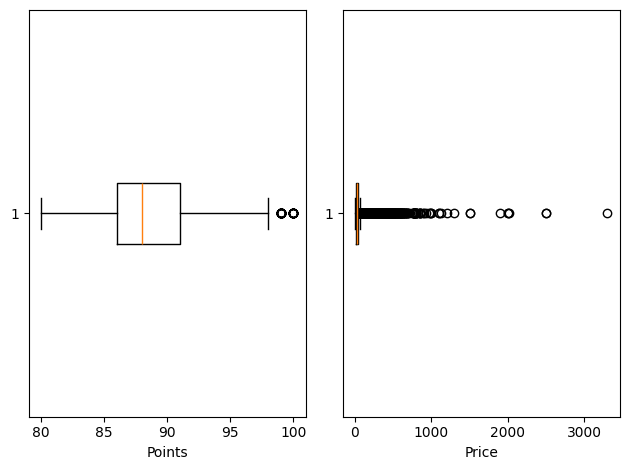

In [ ]:
# visualizing the above stats in boxplot subplots
plt.subplot(1, 2, 1)
plt.boxplot(x = df['points'], vert=False)
plt.xlabel('Points')

plt.subplot(1, 2, 2)
plt.boxplot(x = df['price'], vert=False)
plt.xlabel('Price')

plt.tight_layout()

plt.show()

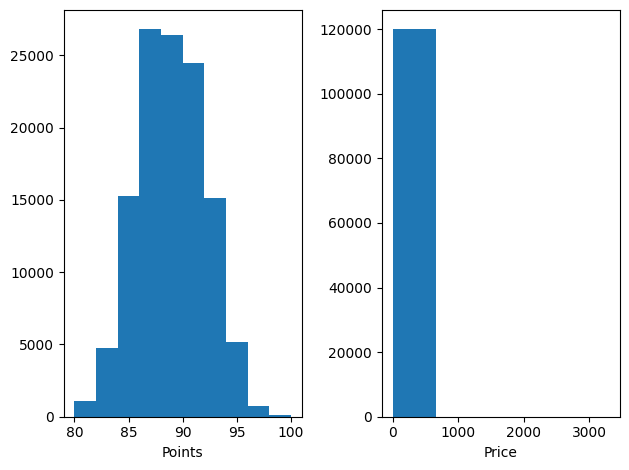

In [ ]:
# Looking at histograms of price and points

plt.subplot(1, 2, 1)
plt.hist(x = df['points'])
plt.xlabel('Points')

plt.subplot(1, 2, 2)
plt.hist(x = df['price'], bins = 5)
plt.xlabel('Price')

plt.tight_layout()

plt.show()

# Both plots show that price has an overwhelming number of outliers and points is pretty much normally distributed.
# Outlier treatment should be given to Price data

So 'points' (the review score) seem to suffer from a massive positive bias, being centered at 88,  

Price on the other hand seem to have some extreme outliers we will need to treat and is probably skewed.

<Axes: xlabel='points', ylabel='price'>

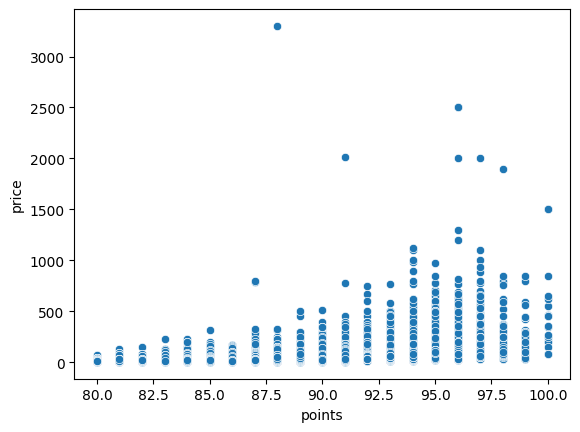

In [ ]:
points = df['points']
price = df['price']

sns.scatterplot(x=points, y=price)

At a cursory glance before any treatment, there does appear to be some correlation between price vs points, but its unclear.

Plan: fit a vanilla linear regression model, then run a significance test

We'll first start with normalizing price by
- removing outliers
- applying some kind of transformation to get a roughly normal distribution

In [ ]:
# experiment with removing outliers in price

# we define this as a sample whose price is 3 standard deviations above the mean
outlier_idxs = df['price'] > 3*df['price'].std()
print(df[outlier_idxs]['price'].describe())

count    2299.000000
mean      215.983906
std       180.626854
min       122.000000
25%       135.000000
50%       155.000000
75%       225.000000
max      3300.000000
Name: price, dtype: float64


In [ ]:
#filtering outliers
df = df[~outlier_idxs]

df[['price', 'points']].describe()

,price,points
count,117689.000000,117689.000000
mean,32.097436,88.349786
std,19.898307,3.027670
min,4.000000,80.000000
25%,18.000000,86.000000
50%,27.000000,88.000000
75%,40.000000,91.000000
max,121.000000,100.000000


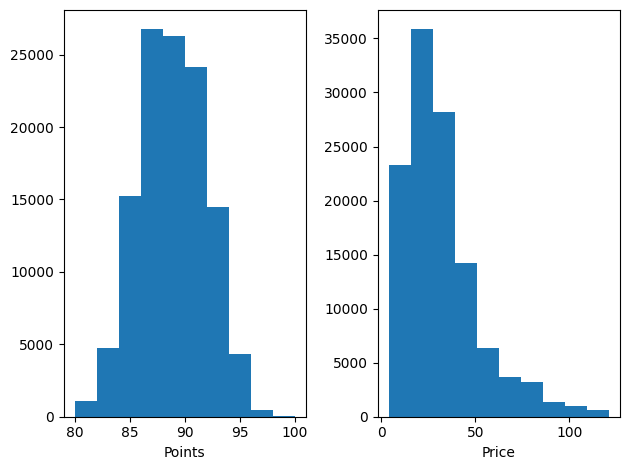

In [ ]:
#now plotting it again, with the outliers removed
plt.subplot(1, 2, 1)
plt.hist(x = df['points'])
plt.xlabel('Points')

plt.subplot(1, 2, 2)
plt.hist(x = df['price'])
plt.xlabel('Price')

plt.tight_layout()

plt.show()
#price is normal, but left skewed

Even with the outliers removed, price is still skewed heavily. Let's experiment with some transforms to see if we can get it to follow at least a normal-ish distribution

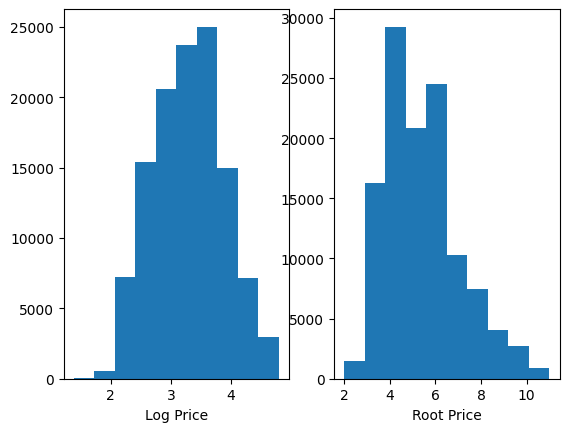

In [ ]:
#lets try transforming the price variable
#price is heavily left skewed, experiment with different transforms

plt.subplot(1, 2, 1)
plt.hist(x = np.log(df['price']))
plt.xlabel('Log Price')

plt.subplot(1, 2, 2)
plt.hist(x = np.sqrt(df['price']))
plt.xlabel('Root Price')
plt.show()

#we'll go with log transform

its not perfect, but we'll proceed with the log transform

In [ ]:
df['log_price'] = np.log(df['price'])

points = df['points']
price = df['log_price']

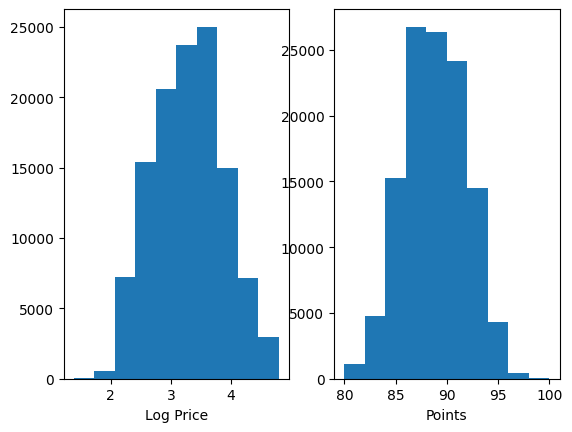

In [ ]:
#plotting again
plt.subplot(1, 2, 1)
plt.hist(x = price)
plt.xlabel('Log Price')

plt.subplot(1, 2, 2)
plt.hist(x = points)
plt.xlabel('Points')
plt.show()
#now both are normal-ish

Lets look at a KDE plot of the newly transformed features



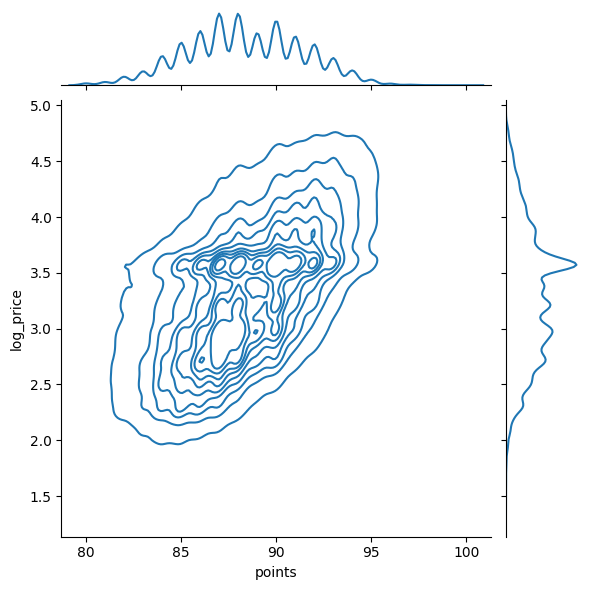

In [ ]:
# comment this out if its taking too long to run
sns.jointplot(x=points, y=price, kind="kde")

Definitely looks like theres some kind of positive trend going on there, lets process the review scores then do a proper regression analysis

# Normalizing review scores (points) with respect to personal biases of each reviewer

Some reviewers will rate high on average, some will rate low on average. If this is the case, normalizing around a globally pooled mean and variance would lead to misleading scores. For example:

Say both John and Jane rate a wine as 80, but John typically rates wines at 40 while Jane typically rates wines at 90. This actually means John LOVED the wine while Jane disliked it.

So we want to figure out if (1) this is the case and (2) if so, normalize based on individual reviewer biases

In [ ]:
# Count of reviews made by each reviewer
# count_by_reviewers = pd.DataFrame(df.groupby(by=['taster_name'], dropna=False)['points'].count())
count_by_reviewers = pd.DataFrame(df.taster_name.value_counts(dropna=False))
count_by_reviewers.columns = ["count"]
count_by_reviewers.head()

,count
taster_name,
anonymous,24429
Roger Voss,22834
Michael Schachner,13846
Kerin O’Keefe,9433
Paul Gregutt,8832


There are a total of 20 unique reviewers


<Axes: title={'center': 'Distribution of number of reviews by reviewers'}, ylabel='Frequency'>

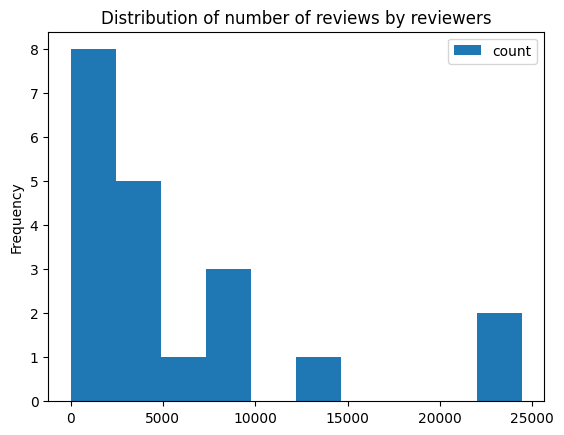

In [ ]:
# Distribution of count of reviews by reviewers
# Some reviewers are super reviewers with like 25000 wine reviews
_ = len(df['taster_name'].unique())
print(f'There are a total of {_} unique reviewers')
count_by_reviewers.plot(kind='hist',grid=False, title='Distribution of number of reviews by reviewers')

It seems like some reviewers are responsible for a massive number of reviews while others are more...moderate in their consumption of alcoholic beverages

What we could do is analyze if the super reviewers tend to rate wine differently from the casual reviewers.

First lets separate the two

In [ ]:
# Lets look at the distribution of ratings made by the super reviewers
# Vs distribution of casual reviewers

# First partition into the 'casual reviewers' and 'super reviewers'
# threshold is set based on mean and std so we define the top 10% of reviewers
# as super reviewers
threshold = 1.28*count_by_reviewers['count'].std() + count_by_reviewers['count'].mean()
super_reviewers = count_by_reviewers[count_by_reviewers['count'] >= threshold]
casual_reviewers = count_by_reviewers[count_by_reviewers['count'] < threshold]

super_ratings = df[df['taster_name'].isin(casual_reviewers.index)]['points']
casual_ratings = df[df['taster_name'].isin(super_reviewers.index)]['points']

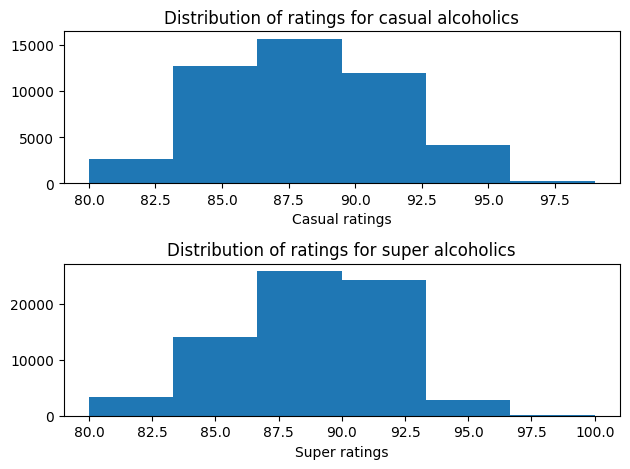

In [ ]:
fig, axs = plt.subplots(2,1)

axs[0].hist(x = casual_ratings, bins=6)
axs[0].set_xlabel('Casual ratings')
axs[0].set_title('Distribution of ratings for casual reviewers')

axs[1].hist(x = super_ratings, bins=6)
axs[1].set_xlabel('Super ratings')
axs[1].set_title('Distribution of ratings for super reveiwers')

fig.tight_layout()
fig.show()

The super alcoholics's distribution skews further right.
If you have tens of thousands of wine reviews, you would like wine a bit more on average.

Lets run a hypothesis test to confirm the reviewers do have skews in rating preferences. We'll run a welch's t-test for difference of mean rating between super reviewers and casual reviewers.

In [ ]:
# Lets do a significance test to see if the super reviewers actually rate
# different from casuals on average
# H0 = same mean ratings
# H1 = different mean ratings
# T test for difference of means
from scipy.stats import ttest_ind
t_stat, p_value = ttest_ind(super_ratings, casual_ratings, equal_var=False)

print(f'P-value for t test for difference of means: {p_value}')
if p_value < 0.05:
  print(f'We can reject the hypothesis that casual and super reviewers rate the same on average')
else:
  print(f'Insufficient evidence that casual and super reviewers have the different distributions')

P-value for t test for difference of means: 2.042446461313823e-105
We can reject the hypothis that casual and super alcoholics rate the same on average


Since we now know that there are definitely biases in reviewers, lets now normalize the review scores with respect to individual reviewer average scores

In [ ]:
# Stratified standardization
df.reset_index(drop=True, inplace=True)

point_means = df.groupby(['taster_name'], dropna=False)['points'].mean()
point_std = df.groupby(['taster_name'], dropna=False)['points'].std()

df['taster_mean'] = point_means[df['taster_name']].reset_index(drop=True)
df['taster_std'] = pd.DataFrame(point_std[df['taster_name']]).reset_index(drop=True)

df['standardized_points'] = (df['points'] - df['taster_mean'])/(df['taster_std'])

In [ ]:
df.drop(['taster_mean', 'taster_std'], axis=1, inplace=True)

In [ ]:
#standardizing prices
df['standardized_price'] = (df['log_price'] - df['log_price'].mean())/(df['log_price'].std())

Now that that's done, lets move on to the actual regression analysis

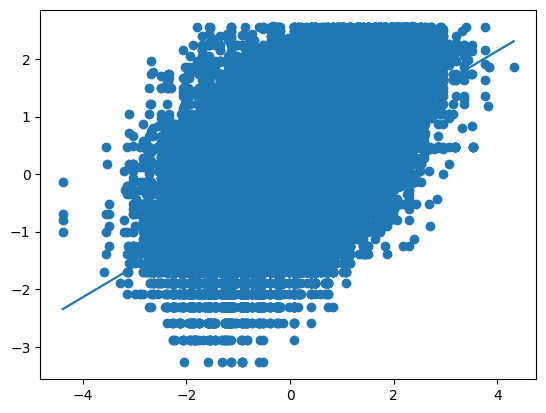

In [ ]:
import statsmodels.api as sm


def simple_regplot(
    x, y, n_std=2, n_pts=100, ax=None, scatter_kws=None, line_kws=None, ci_kws=None
):
    """ Draw a regression line with error interval. """
    ax = plt.gca() if ax is None else ax

    # calculate best-fit line and interval
    x_fit = sm.add_constant(x)
    fit_results = sm.OLS(y, x_fit).fit()

    eval_x = sm.add_constant(np.linspace(np.min(x), np.max(x), n_pts))
    pred = fit_results.get_prediction(eval_x)

    # draw the fit line and error interval
    ci_kws = {} if ci_kws is None else ci_kws
    ax.fill_between(
        eval_x[:, 1],
        pred.predicted_mean - n_std * pred.se_mean,
        pred.predicted_mean + n_std * pred.se_mean,
        alpha=0.5,
        **ci_kws,
    )
    line_kws = {} if line_kws is None else line_kws
    h = ax.plot(eval_x[:, 1], pred.predicted_mean, **line_kws)

    # draw the scatterplot
    scatter_kws = {} if scatter_kws is None else scatter_kws
    ax.scatter(x, y, c=h[0].get_color(), **scatter_kws)

    return fit_results

res = simple_regplot(df['standardized_points'], df['standardized_price'])

In [ ]:
#regression statistics
#F statistics shows the regression is significant
#but the correlation coef is weak
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:     standardized_price   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                 4.717e+04
Date:                Thu, 12 Dec 2024   Prob (F-statistic):               0.00
Time:                        00:44:24   Log-Likelihood:            -1.4716e+05
No. Observations:              117689   AIC:                         2.943e+05
Df Residuals:                  117687   BIC:                         2.943e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                2.704e-16    

The regression shows a weak but undeniably significant correlation between how expensive a wine is and how highly its rating.

So expensive wines are more likely to be preferred, but there are many other factors at play is the conclusion

# NLP text preprocessor

In [ ]:
# Preprocessing the reviews
tqdm.pandas()

nlp = spacy.load("en_core_web_sm")
stop_words = set(
    stopwords.words('english')
    + [
        "flavor",
        "wine",
        "fruit",
        "be",
        "finish",
        "aroma",
        "palate",
        "acidity",
        "tannin",
        "note",
        "nose"
    ]
)

def preprocess_text(text):
    doc = nlp(text.lower())

    # Remove stopwords and punctuation, and perform lemmatization
    processed_tokens = [
        token.lemma_ for token in doc
        if (
            (token.lemma_ not in stop_words)  #remove all stop words
            and (token.text not in string.punctuation)  #remove all punctuation
            and (token.pos_ in {"NOUN", "ADJ"}) #only include nouns and adjectives
        )
    ]
    processed_tokens = list(set(processed_tokens)) #only keep unique tokens

    return " ".join(processed_tokens)

# example preprocessed text
print(df['description'][0])
print(df["description"][:1].apply(preprocess_text)[0])

Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.
brimstone sage brisk broom herb unripened citrus tropical apple expressive


In [ ]:
from collections import Counter
#Collect word counts from reviews
def get_word_counts(sample, title="Looking at this sample of reviews"):
  word_counts = dict(Counter("".join(sample.values).split(" ")))
  word_counts = pd.DataFrame.from_dict(
      word_counts,
      orient='index',
      columns=["count"]
  ).sort_values(
      by="count",
      ascending=False
  )
  word_counts[:10].plot(
    kind="bar",
    grid=False,
    title=title
  )
  return word_counts

100%|██████████| 1000/1000 [00:25<00:00, 39.08it/s]


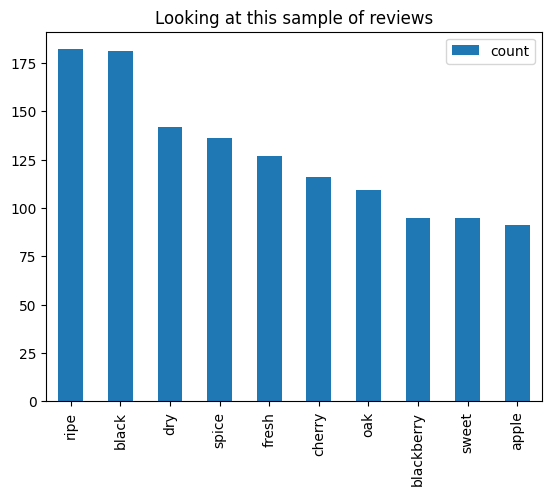

In [ ]:
sample = df.sample(n=1000)['description'].progress_apply(preprocess_text)
word_counts = get_word_counts(sample)

100%|██████████| 1000/1000 [00:17<00:00, 55.68it/s]


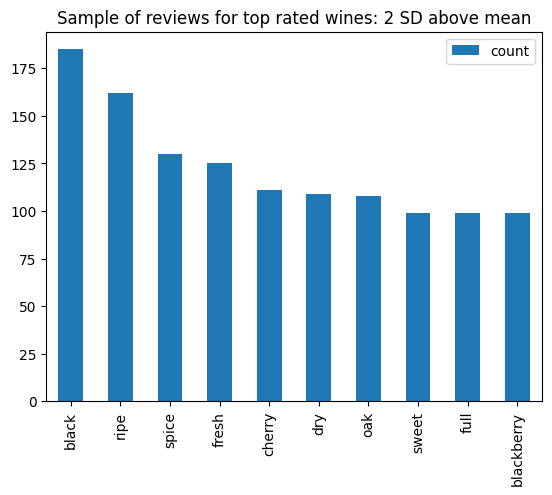

In [ ]:
# Now looking at sample of top rated wines: 2 SD above mean
sample = df[df.points < df.points.mean() + 2*df.points.std()].sample(n=1000)['description'].progress_apply(preprocess_text)
word_counts = get_word_counts(sample, title='Sample of reviews for top rated wines: 2 SD above mean')

100%|██████████| 1000/1000 [00:15<00:00, 66.62it/s]


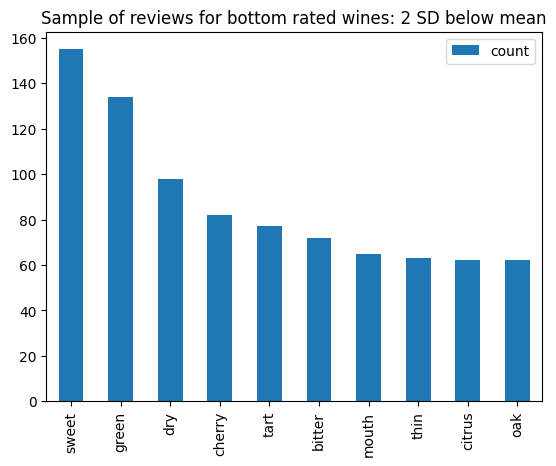

In [ ]:
# Now looking at sample of bottom rated wines: 2 SD below mean
sample = df[df.points < df.points.mean() - 2*df.points.std()].sample(n=1000)['description'].progress_apply(preprocess_text)
word_counts = get_word_counts(sample, title='Sample of reviews for bottom rated wines: 2 SD below mean')

# Pretrained sentence embedding model

Lets load a pretrained encoder and see how well it captures semantic content of reviews by default

The idea is there are some reviews in the dataset which discusses the same wine, we can treat these as positive pairs. We can then randomly sample some other reviews to use as negative pairs.

If the encoder works well, it should be able to tell which of the reviews are of the same wine--by assigning their embeddings a high cosine similarity score

In [ ]:
%%capture
!pip install evaluate
!pip install bert_score

In [ ]:
# Load the models
from sentence_transformers import (
    SentenceTransformer,
    models,
    InputExample,
    losses
)
# from datasets import load_dataset
from torch.utils.data import DataLoader
from sentence_transformers import InputExample
from evaluate import load

model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")

import textwrap
from sklearn.metrics.pairwise import cosine_similarity
# from evaluate import load

# This function is just for prettifying the visualizations later on
def wrap_labels(ax, width, break_long_words=False):
    #for x
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

# This function is for generating a heatmap visualization of the embedding's cosine similarity matrix
def get_heatmap(heatmap_dataframe):
    plt.figure()
    ax = sns.heatmap(heatmap_dataframe, annot=True, cmap="rocket", vmin = 0, vmax = 1, yticklabels=False)
    ax.set(xlabel="", ylabel="")
    ax.set_xticklabels(labels = heatmap_dataframe.columns)
    # ax.set_yticklabels(labels = heatmap_dataframe.index)
    ax.xaxis.tick_top()
    wrap_labels(ax, 10)

# This function takes in an array of strings, generates the embeddings for each, then returns the cosine sim matrix
def get_cosine_similarities(string_array, render=False):
    num_chunks = len(string_array)
    return_matrix = np.array([model.encode(string_array[0])])
    for i in range(num_chunks-1):
        string = string_array[i+1]
        cls_embedding = np.array([model.encode(string)])
        return_matrix = np.append(return_matrix, cls_embedding, axis = 0)

    cosine_matrix = cosine_similarity(return_matrix)
    return_df = pd.DataFrame(cosine_matrix, columns=string_array, index=string_array)

    if(render):
        get_heatmap(return_df)
    return(return_df)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Now we'll sample five wine review descriptions, the first two of which are descriptions of the same wine. We'll pass these to our encoder and generate a bunch of pair-wise cosine similarity scores and visualize it in a matrix.

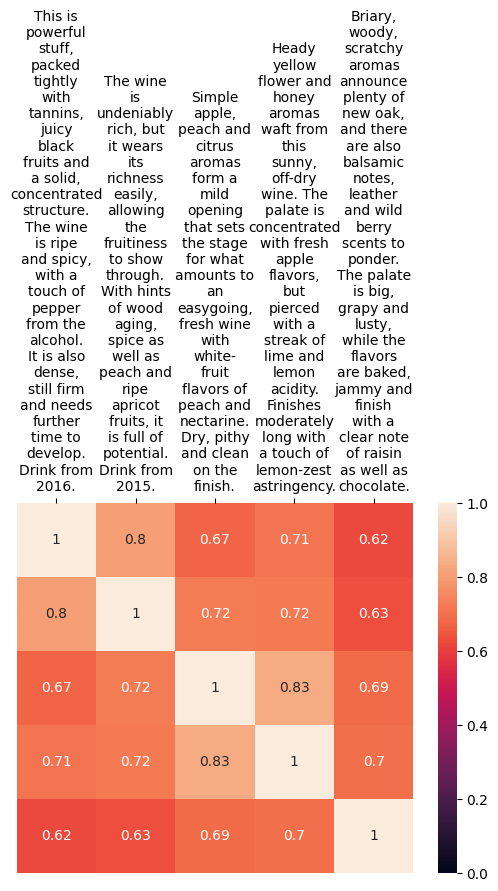

In [ ]:
# Randomly samples five reviews, the first two reviews are of the same wine
sample = pd.concat([
    df[df.title == count_titles[count_titles>=2].sample(n=2).index[0]][:2]["description"], #may god forgive me for this
    df["description"].sample(n=3)
])

# visualize
string_arr = sample.values
cls_cosine_mat = get_cosine_similarities(string_arr, render=True)

Looks okay, but this isn't conclusive.

We should test properly through more than just a single anecdotal test. The evaluation procedure will be similar:

1. Sample 2 reviews of the same wine, then sample 3 reviews randomly
2. If embeddings between the 2 reviews are most similar with each other, that is considered a 'correct' prediction, 'incorrect' otherwise
3. repeat this n times, then average results

The baseline accuracy with this should be ~10%

In [ ]:
# Eval function
def eval_accuracy(n=100, preprocess=False):
  num_corrects = 0
  for i in tqdm(range(n)):
    # We sample 2 reviews which are of the same wine
    # We then sample 3 other reviews at random
    # If the model correctly ranks 2 of the reviews as being most similar to each
    # other, that is defined as a correct prediction

    # IE: the baseline accuracy is: 1 / (5 choose 2)
    # or 10%
    string_array = pd.concat([
      df[df.title == count_titles[count_titles>=2].sample(n=1).index[0]][:2]["description"], #may god forgive me for this
      df["description"].sample(n=3)
    ])

    if preprocess:
      string_array = string_array.apply(preprocess_text).values
    else:
      string_array = string_array.values

    num_chunks = len(string_array)
    return_matrix = np.array([model.encode(string_array[0])])
    for i in range(num_chunks-1):
        string = string_array[i+1]
        cls_embedding = np.array([model.encode(string)])
        return_matrix = np.append(return_matrix, cls_embedding, axis = 0)

    cosine_scores = np.triu(cosine_similarity(return_matrix), k=1)
    pred = np.argmax(cosine_scores[:2])
    num_corrects += np.sum(pred == 1)
  acc = num_corrects/n
  print(f'\n')
  print(f'accuracy: {acc} +- {1.96*((acc)*(1-acc)/n)**(1/2)}')

In [ ]:
# Evaluating the encoder's accuracy without any preprocessing
eval_accuracy(100)
# Evaluating the encoder's accuracy with the aggressive preprocessing
eval_accuracy(100, preprocess=True)

100%|██████████| 100/100 [02:43<00:00,  1.64s/it]




accuracy: 0.51 +- 0.09798039803960791


100%|██████████| 100/100 [01:42<00:00,  1.03s/it]



accuracy: 0.3 +- 0.08981848362113447


We seem to get better results without the agressive preprocessing, most likely because the sentence transformer function is expecting unprocessed sentences and has its own preprocessing steps.

Having said that, the unprocessed accuracy is above baseline, but still less than desirable

There are several ways to interpret this:
1. The encoder needs to be fine-tuned to achieve a better accuracy. This makes sense on the surface, but is kind of naive for a reason im about to get into
2. Reviewers are not robots and aren't guaranteed to describe the same wine the same way to begin with. We expect that they describe the same wine in similar ish ways, but to what degree is unclear and difficult to quantify. On top of that, remember that this is a blind taste test and that there COULD just be wine that tastes similar to each other.

Like in a linear regression, the SSR is capped by the natural noise in the dataset. We can almost think of the same thing here as "natural language noise".

The fact that this performs higher than baseline random chance predictions indicates
1. That reviewers DO describe the same wine things consistently, albeit with some NLP noise
2. Given the performance and the low stakes nature of this task, a good use might be as a "search tool" for customers. Customers describe their perfect wine, and we match it against the wine with reviews most similar to their description

# Analyzing actual Wine Reviews and how customers are describing the wine

# Looking at parts of speech specifically adjectives used to describe the wine like if taste is a major way they describe it then we want to check for adjectives like bitter or sweet

May need to consider not just good or bad since many of the subjects who review the wines are professionals when it comes to assessing wine quality and history so need to take that into account

In [ ]:
df['description']

,description
0,"Aromas include tropical fruit, broom, brimston..."
1,"This is ripe and fruity, a wine that is smooth..."
2,"Tart and snappy, the flavors of lime flesh and..."
3,"Pineapple rind, lemon pith and orange blossom ..."
4,"Much like the regular bottling from 2012, this..."
...,...
117684,Notes of honeysuckle and cantaloupe sweeten th...
117685,Citation is given as much as a decade of bottl...
117686,Well-drained gravel soil gives this wine its c...
117687,"A dry style of Pinot Gris, this is crisp with ..."


In [ ]:
df['description'][1]

"This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's  already drinkable, although it will certainly be better from 2016."

In [ ]:
min = df['points'].min()
df[df['points'] == min].count()

,0
points,397
title,397
description,397
taster_name,397
taster_twitter_handle,271
price,397
designation,250
variety,397
region_1,328
region_2,136


In [ ]:
min = df["points"].min()
df.index[df["points"] == min]

Index([   342,   3559,   3560,   4460,   4461,   5776,   5777,   5778,   5779,
         5780,
       ...
       114253, 116291, 116292, 116293, 116294, 116295, 116296, 116297, 116298,
       116299],
      dtype='int64', length=397)

In [ ]:
df['description'][10002]

"This dry, single-vineyard bottling is extremely aromatic, as only Gewürztraminer can be. The ripe lychee and grapefruit is subsumed in a cloud of baby powder. It's quite dry, and for those that want a supremely floral varietal expression of this grape, this is your go-to bottle."

In [ ]:
# def get_description_by_points(points):
#   min = df['points'].min()
#   max = df['points'].max()
#   if points in range(min, max):
#     any_points = df[df['points'] == points]
#     point_description = df.groupby(by=any_points)['description']
#     point_description

In [ ]:
# get_description_by_points(80)

In [ ]:
!pip install nltk

In [ ]:
# Split the points into low (80-90) and high (90-100) then tokenize descriptions for low and high (without removing stopwords)
from nltk import sent_tokenize, word_tokenize
from collections import Counter
low_points = df[df['points'] < 90]
high_points = df[df['points'] >= 90]
low_descriptions = low_points['description'].apply(word_tokenize)
high_descriptions = high_points['description'].apply(word_tokenize)

NameError: name 'df' is not defined

In [ ]:
# Count up the tokens in low and high and plot them side by side (without removing stop words)
from prettytable import PrettyTable
low_point_tok_count_table = PrettyTable()
low_point_tok_count_table.field_names = ["Low_Token", "Count"]
high_point_tok_count_table = PrettyTable()
high_point_tok_count_table.field_names = ["high_Token", "Count"]
low_point_tok_count = Counter(word for description in low_descriptions for word in description)
high_point_tok_count = Counter(word for description in high_descriptions for word in description)
for point in len(pd.Series.unique(low_points)):
  low_point_tok_count_table.add_row([point, low_point_tok_count[point]])
for point in len(pd.Series.unique(high_points)):
  high_point_tok_count_table.add_row([point, high_point_tok_count[point]])
print(low_point_tok_count_table)
print(high_point_tok_count_table)

# plotting
x = ['Low Points', 'High Points']
low_counts = [low_point_tok_count[point] for point in low_point_tok_count.values()]
high_counts = [high_point_tok_count[point] for point in high_point_tok_count.values()]
plt.figure(figsize=(8, 6))
plt.bar(x, low_counts, label='Low Points', color='olive')
plt.bar([pos + 0.2 for pos in range(len(x))], high_counts, label='High Points', color='skyblue')
plt.xlabel('Point category')
plt.ylabel('Token count')
plt.title('Token count by point category')
plt.xticks([i + 0.1 for i in range(len(x))], x)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.8)
plt.tight_layout()
plt.show()


In [ ]:
# Do the same thing as above this time removing stop words
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
low_descriptions_no_stop = low_points['description'].apply(word_tokenize).apply(lambda x: [word for word in x if word.lower() not in stop_words])
high_descriptions_no_stop = high_points['description'].apply(word_tokenize).apply(lambda x: [word for word in x if word.lower() not in stop_words])

In [ ]:
# Count up the tokens in low and high and plot them side by side (with removing stop words)
from prettytable import PrettyTable
low_point_tok_count_table = PrettyTable()
low_point_tok_count_table.field_names = ["Low_Token_no_stop", "Count"]
high_point_tok_count_table = PrettyTable()
high_point_tok_count_table.field_names = ["high_Token_no_stop", "Count"]
low_point_tok_count_no_stop = Counter(word for description in low_descriptions_no_stop for word in description)
high_point_tok_count_no_stop = Counter(word for description in high_descriptions_no_stop for word in description)
for point in len(pd.Series.unique(low_points)):
  low_point_tok_count_table.add_row([point, low_point_tok_count_no_stop[point]])
for point in len(pd.Series.unique(high_points)):
  high_point_tok_count_table.add_row([point, high_point_tok_count_no_stop[point]])
print(low_point_tok_count_table)
print(high_point_tok_count_table)

# plotting no stop
x = ['Low Points', 'High Points']
low_counts = [low_point_tok_count_no_stop[point] for point in low_point_tok_count_no_stop.values()]
high_counts = [high_point_tok_count_no_stop[point] for point in high_point_tok_count_no_stop.values()]
plt.figure(figsize=(8, 6))
plt.bar(x, low_counts, label='Low Points', color='olive')
plt.bar([pos + 0.2 for pos in range(len(x))], high_counts, label='High Points', color='skyblue')
plt.xlabel('Point category')
plt.ylabel('Token count no stopwords')
plt.title('Token count with no stopwords by point category')
plt.xticks([i + 0.1 for i in range(len(x))], x)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.8)
plt.tight_layout()
plt.show()

In [ ]:
# Why is this analysis potentially helpful? If there is a difference in the number of words in the lower rated wines then company managers can understand the structure of negative reviews
# and use maybe the number of words in the reviews as a measure and run deeper analysis on those words rather than try to read through each review and figure out what improvements they can make to the wine batches.

In [ ]:
# creating pie charts to see what % of the words are adjectives in all reviews in low_point_descriptions and high_point_descriptions
from nltk import pos_tag
low_tag = low_descriptions_no_stop.apply(pos_tag)
high_tag = high_descriptions_no_stop.apply(pos_tag)
low_adj = low_tag.apply(lambda x: [word for word, tag in x if tag in ['JJ', 'JJR', 'JJS']])
high_adj = high_tag.apply(lambda x: [word for word, tag in x if tag in ['JJ', 'JJR', 'JJS']])
low_adj_count = Counter(word for description in low_adj for word in description)
high_adj_count = Counter(word for description in high_adj for word in description)
low_adj_percent = (low_adj_count / low_point_tok_count_no_stop) * 100
high_adj_percent = (high_adj_count / high_point_tok_count_no_stop) * 100
low_adj_percent = low_adj_percent.fillna(0)
high_adj_percent = high_adj_percent.fillna(0)
plt.subplot(1, 2, 1)
plt.pie(low_adj_percent, labels=['Adj', 'other'], autopct='%1.1f%%', startangle=90)
plt.title('Low Points')
plt.subplot(1, 2, 2)
plt.pie(high_adj_percent, labels=['Adj', 'other'], autopct='%1.1f%%', startangle=90)
plt.title('High Points')
plt.tight_layout()
plt.show()


In [ ]:
# From the piecharts we can see if adjectives are significant enough to run a word2vec or other embedding model on them to find out what wine related adjectives are used in lower rated wines and higher
# rated wines. For example bitter or dry could be used more in lower rated wines and sweet or delectable could be used in higher rated wines. To capture these relationships a embedding model
# would be desirable. Another way to use the model is often times for good wines reviewers refer to the history to describe when it started and use history to hint at quality

In [ ]:
df[df['points'] == 100]['description']

,description
345,This wine contains some material over 100 year...
7335,Thick as molasses and dark as caramelized brow...
36528,This is a fabulous wine from the greatest Cham...
39286,"A perfect wine from a classic vintage, the 200..."
42197,This is the latest release of what has long be...
45781,"This gorgeous, fragrant wine opens with classi..."
45798,Tasted in a flight of great and famous Napa wi...
58352,"This is a magnificently solid wine, initially ..."
89728,This latest incarnation of the famous brand is...
89729,This new release from a great vintage for Char...
